Copyright **`(c)`** 2023 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# LAB9

Write a local-search algorithm (eg. an EA) able to solve the *Problem* instances 1, 2, 5, and 10 on a 1000-loci genomes, using a minimum number of fitness calls. That's all.

### Deadlines:

* Submission: Sunday, December 3 ([CET](https://www.timeanddate.com/time/zones/cet))
* Reviews: Sunday, December 10 ([CET](https://www.timeanddate.com/time/zones/cet))

Notes:

* Reviews will be assigned  on Monday, December 4
* You need to commit in order to be selected as a reviewer (ie. better to commit an empty work than not to commit)

In [91]:
from random import choices
from random import random, choice, randint, sample, uniform, seed
from copy import copy
from dataclasses import dataclass
import matplotlib.pyplot as plt

from tabulate import tabulate

import lab9_lib


In [92]:
OFFSPRING_SIZE = 60
POPULATION_SIZE = 30
MUTATION_PROBABILITY = .05
NUM_LOCI = 1000
PROBLEM = [1, 2, 5, 10]
# seed(20)
seed(20)


## Individual

- The individual is organized as a class where fitness is the fitness value of the individual and the genotype is a list of 1000 integers (0/1)
- The individual also has a function to perform the mutation and a functon to perform the xover

In [93]:
@dataclass
class Individual:
    fitness: tuple
    genotype: list[int]

# NOT USED
def tournament_selection(population, tournament_size):
    # Randomly select individuals for the tournament
    tournament = sample(population, tournament_size)
    # Return the individual with the highest fitness
    return max(tournament, key=lambda ind: ind.fitness)


def roulette_wheel_selection(population):
    # Calculate the total fitness of the population
    total_fitness = sum(ind.fitness for ind in population)
    # Select a random value between 0 and the total fitness
    selection_point = uniform(0, total_fitness)
    # Go through the population and sum the fitness from 0, stop when the sum is greater than the selection point
    current_sum = 0
    for ind in population:
        current_sum += ind.fitness
        if current_sum > selection_point:
            return ind


# Given the genome, select randomly a gene and switch is value
def mutate(ind: Individual) -> Individual:
    offspring = copy(ind)
    pos = randint(0, NUM_LOCI - 1)

    if offspring.genotype[pos] == 1:
        offspring.genotype[pos] = 0
    else:
        offspring.genotype[pos] = 1
    offspring.fitness = None
    return offspring


# Give the genome of two individual, create a new offspring by removing a portion of the genome from Ind1 and substituting it with the corresponding portion of Ind2
def one_cut_xover(ind1: Individual, ind2: Individual) -> Individual:
    # Generate two random cut points within the genotype range
    cut_point1, cut_point2 = sorted([randint(0, NUM_LOCI - 1) for _ in range(2)])

    # Ensure cut points are within valid range
    cut_point1 = max(0, cut_point1)
    cut_point2 = min(NUM_LOCI, cut_point2)

    # Perform crossover
    offspring_genotype = (
        ind1.genotype[:cut_point1]
        + ind2.genotype[cut_point1:cut_point2]
        + ind1.genotype[cut_point2:]
    )

    # Create the offspring
    offspring = Individual(fitness=None, genotype=offspring_genotype)

    assert len(offspring.genotype) == NUM_LOCI

    return offspring

## Initial Population

- The initial population of size *POPULATON_SIZE* is created randomly with more probability to have a 0 then 1 in a locus
- For each individual in the initial population, we evaluate the fitness



In [94]:
def generate_init_population(fitness):
    weights = [0.9,0.1]
    population = [
        Individual(
            genotype = choices([0,1], weights=weights, k=NUM_LOCI),
            fitness=None,
        )
        for _ in range(POPULATION_SIZE)
    ]

    for i in population:
        i.fitness = fitness(i.genotype) 
    return population

## EA-Algorithm
- Given the initial population, the algorithm select wit a certain probability, to create a given number of offsprings using two different techniques (mutation,xover)
- The population is extended with the offsprings and than it's trimmed, letting survive only the best individuals
- The algorithm is stopped when there are no improvements in the fitness (0.5% of variations in fitness in the last 100 generations) or if the value of the fitenss reachs 1

In [95]:
def evolutionary_algorithm(fitness, population):
    generation = 0
    fitness_history = []
    while True:
        offspring = []

        for _ in range(OFFSPRING_SIZE):
            if random() < MUTATION_PROBABILITY:
                # mutation
                parent = roulette_wheel_selection(population)
                child = mutate(parent)
            else:
                # xover
                parent1 = roulette_wheel_selection(population)
                parent2 = roulette_wheel_selection(population)
                child = one_cut_xover(parent1, parent2)
            offspring.append(child)

        for ind in offspring:
            ind.fitness = fitness(ind.genotype)

        population.extend(offspring)
        population.sort(key=lambda ind: ind.fitness, reverse=True)

        ind = population[0]

        population = population[:POPULATION_SIZE]

        current_fitness = ind.fitness

        # Append the fitness to the history
        fitness_history.append(current_fitness)

    

        # Check termination condition
        if generation >= 600:
            recent_fitness_variation = max(fitness_history[-600:]) - min(
                fitness_history[-600:]
            )
            if (
                recent_fitness_variation < 0.005 or current_fitness == 1
            ):  # 0.5% variation or current_fitness is 1
                print(
                    f"Terminating at generation {generation} due to low fitness variation or current_fitness reached 1."
                )
                break

        generation += 1
    return fitness_history

# Problem Results

- In this section the EA algorithm produces results for the different istances of the problem we have, showing results on a plot

Terminating at generation 2008 due to low fitness variation or current_fitness reached 1.
Terminating at generation 3561 due to low fitness variation or current_fitness reached 1.
Terminating at generation 5527 due to low fitness variation or current_fitness reached 1.
Terminating at generation 7763 due to low fitness variation or current_fitness reached 1.


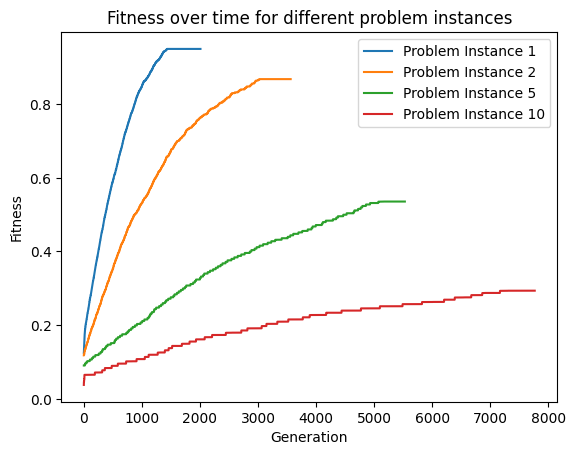

+-----------------------------+---------------+
|      Problem Instance       | Final Fitness |
+-----------------------------+---------------+
| Problem Instance 1, 95.00%  |    120570     |
| Problem Instance 2, 86.80%  |    213750     |
| Problem Instance 5, 53.56%  |    331710     |
| Problem Instance 10, 29.36% |    465870     |
+-----------------------------+---------------+


In [96]:
problem_instances = PROBLEM
fitness_histories = []
call_history = []

for instance in problem_instances:
    # Initialize your problem here with the current instance
    fitness = lab9_lib.make_problem(instance)

    init_population = generate_init_population(fitness)

    fitness_history = evolutionary_algorithm(fitness, init_population)

    # Append the fitness history of this run to the fitness_histories list
    fitness_histories.append(fitness_history)
    
    call_history.append(fitness.calls)

# Plot the results
for i, fitness_history in enumerate(fitness_histories):
    plt.plot(fitness_history, label=f"Problem Instance {problem_instances[i]}")

plt.title("Fitness over time for different problem instances")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend()
plt.show()


table_data = []
for i, instance in enumerate(problem_instances):
    table_data.append([f"Problem Instance {instance}, {fitness_histories[i][-1]:.2%}", call_history[i]]) 

table_headers = ["Problem Instance", "Final Fitness", "Fitness Calls"]
table = tabulate(table_data, headers=table_headers, tablefmt="pretty")

print(table)